## Template Matching Pick Timing Examples

Code by: Hafiz Issah, aissah@mines.edu

This notebook uses DAS data from the Bradys Hot Springs (from the Geothermal Data Repository, recorded by the PoroTomo Team), and analyzes pick timing of three small events using template matching with a known event. The standard workflow (without compression) for template matching is based on *****CITATION*****. It uses multiple compression types ZFP, wavelets, and SVD at several compression ratios to compare the changes in pick times throughout the full DAS array due to compression/decompression.

In [14]:
import os, sys
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
import scipy.signal as ss
import zfpy
import operator
import matplotlib

sys.path.insert(0, os.path.abspath('..'))

from Functions import eventDTFuncs, general_funcs


matplotlib.rcParams["figure.figsize"] = (8,6)

The wavelet compression will be Daubechies 5 wavelets. The analyses will be done at 5x, 10x, 20x and 50x compression ratios. The data analyzed will be channels 1000 to 5000. ******note: need to fix this - inconsistent use of channels? add comments to things like lagmax ****

In [15]:
wavelet='db5'
level=5
templateSamples=[17240, 23256]
channelsToUse=range(1000,5000)
lagmax=28000
compression_ratios=[0,5,10,20,50,100]
samples_per_sec=1000

Here, we load data from hdf5 format files. 

In [16]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_=general_funcs.loadBradyHShdf5(file,normalize='no')
data = eventDTFuncs.brady_preprocess(data)
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_=general_funcs.loadBradyHShdf5(file,normalize='no')
data2 = eventDTFuncs.brady_preprocess(data2)

The template event and the continuously recorded noise to be compared to the template event are extracted. 

In [17]:
channelsToUse=range(1500,4500)

template = data[::-1][channelsToUse[0]:channelsToUse[-1]]
filtered_template = general_funcs.frequency_filter(template, [1, 15], "bandpass", 5, 1000)
filtered_template = filtered_template[:, templateSamples[0] : templateSamples[1]]
template = template[:, templateSamples[0] : templateSamples[1]]

maxes = np.max(filtered_template, axis=1) 
filtered_template = filtered_template/maxes[:,np.newaxis]

maxes = np.max(template, axis=1) 
template = template/maxes[:,np.newaxis]

signalToUse = np.append(data[:, 24976:], data2, axis=1)
signalToUse = signalToUse[::-1][channelsToUse[0]:channelsToUse[-1]]
filtered_signalToUse = general_funcs.frequency_filter(signalToUse, [1, 15], "bandpass", 5, 1000)
maxes = np.max(filtered_signalToUse, axis=1) 
filtered_signalToUse = filtered_signalToUse/maxes[:,np.newaxis]

maxes = np.max(signalToUse, axis=1) 
signalToUse = signalToUse/maxes[:,np.newaxis]

lagmax = len(signalToUse[0]) - len(template[0])

This function calculates the times when normalized cross-correlations (from template matching) have their peak envelope amplitudes, and this is done for each channel. 

In [18]:
def CC_peak_locations(cross_correlations, peak_windows, timeLag, envelope="yes"):
    
    if envelope=="yes":
        traces=np.abs(ss.hilbert(cross_correlations, axis=1))
    else:
        traces=cross_correlations
    if cross_correlations.ndim==1:
        peaksLocs=[]
        for b in peakWindows:
            max_idx, max_val = max(enumerate(env[b[0]:b[1]]), key=operator.itemgetter(1)) 
            peaks.append(timeLag[max_idx+ b[0]])
        peakLocs=np.append(peakLocs, np.array([peaks]), axis=0)
    else:
        peakLocs=np.empty((1,len(peakWindows)))
        for env in traces:
            peaks=[]
            for b in peakWindows:
                max_idx, max_val = max(enumerate(env[b[0]:b[1]]), key=operator.itemgetter(1)) 
                peaks.append(timeLag[max_idx+ b[0]])
            peakLocs=np.append(peakLocs, np.array([peaks]), axis=0)
        peakLocs=peakLocs[1:]
    return peakLocs

### Wavelet compression analysis

For 3 event time windows (see the Three\_Events.ipynb file for more info), the template matching times of the 2D wavelet compressed/decompressed data are calculated, as well as the times resulting from template matching of the raw data. This is repeated for each 2D wavelet compression ratio.

In [19]:
peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
timeLag=np.linspace(0,lagmax/1000,lagmax)
chosen_channels_signal= signalToUse #[channelsToUse]
chosen_channels_template = template #[channelsToUse]
lag_zero=len(template[1])-1
number_of_channels=len(signalToUse)
peakLocations=np.empty((1,number_of_channels,len(peakWindows)))
for comp_ratio in compression_ratios:
    if comp_ratio == 0:
        decompressed_signal = filtered_signalToUse
        decompressed_template = filtered_template
    else:
        decompressed_signal, _ = general_funcs.compressReconstruct_wavelets(chosen_channels_signal, mode="1D", wavelet=wavelet, lvl=level, compressionFactor=comp_ratio)
        decompressed_template, _ = general_funcs.compressReconstruct_wavelets(chosen_channels_template, mode="1D", wavelet=wavelet, lvl=level, compressionFactor=comp_ratio)
        decompressed_signal = general_funcs.frequency_filter(decompressed_signal, [1, 15], "bandpass", 5, 1000)
        decompressed_template = general_funcs.frequency_filter(decompressed_template, [1, 15], "bandpass", 5, 1000)
    peakLocs=np.empty((1,len(peakWindows)))
    for a in range(number_of_channels):
        oneChannelTM=ss.correlate(decompressed_signal[a], decompressed_template[a])
        oneChannelTM=oneChannelTM[lag_zero:lag_zero+lagmax]
        # env=np.abs(ss.hilbert(oneChannelTM))
        peaks=[]
        for b in peakWindows:
            max_idx, max_val = max(enumerate(oneChannelTM[b[0]:b[1]]), key=operator.itemgetter(1)) 
            peaks.append(timeLag[max_idx+ b[0]])
        peakLocs=np.append(peakLocs, np.array([peaks]), axis=0)
    peakLocs=peakLocs[1:]
    peakLocations=np.append(peakLocations, peakLocs[np.newaxis], axis=0)

peakLocations = peakLocations[1:]

Plot the distribution across all channels of differences between each compression level's picked times and the original data's picked times for all three events.

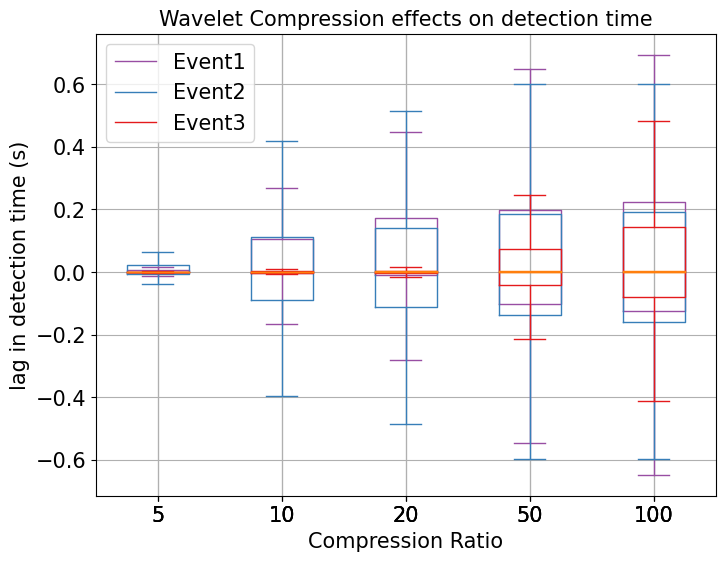

In [20]:
fsize=15
labels=[str(compression_ratios[a]) for a in range(1,6)]
colors=["#984ea3","#377eb8","#e41a1c"]
bps=[]
plt.figure(figsize=(8, 6))
for b in range(len(peakWindows)):
    boxpData=[peakLocations[a,:,b]-peakLocations[0,:,b] for a in range(1,6)]
    bp=plt.boxplot(boxpData, labels=labels, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'caps']: #['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']
            plt.setp(bp[element], color=colors[b])
    bps.append(bp)
plt.grid()
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel("lag in detection time (s)",fontsize=fsize)
plt.xlabel("Compression Ratio",fontsize=fsize)
plt.title("Wavelet Compression effects on detection time",fontsize=fsize)
plt.legend([a["boxes"][0] for a in bps],["Event1","Event2","Event3"],fontsize=fsize)

Same plot as above, but only including up to 50x compression. 

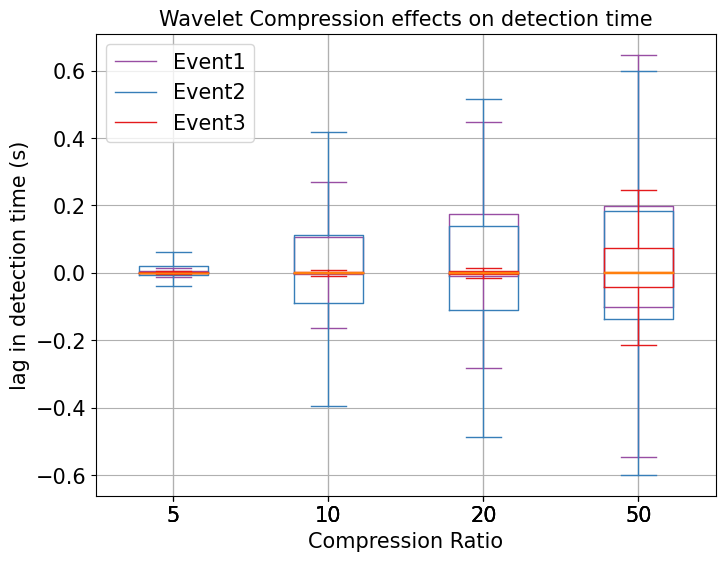

In [21]:
fsize=15
labels=[str(compression_ratios[a]) for a in range(1,5)]
colors=["#984ea3","#377eb8","#e41a1c"]
bps=[]
plt.figure(figsize=(8, 6))
for b in range(len(peakWindows)):
    boxpData=[peakLocations[a,:,b]-peakLocations[0,:,b] for a in range(1,5)]
    bp=plt.boxplot(boxpData, labels=labels, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'caps']: #['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']
            plt.setp(bp[element], color=colors[b])
    bps.append(bp)
plt.grid()
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel("lag in detection time (s)",fontsize=fsize)
plt.xlabel("Compression Ratio",fontsize=fsize)
plt.title("Wavelet Compression effects on detection time",fontsize=fsize)
plt.legend([a["boxes"][0] for a in bps],["Event1","Event2","Event3"],fontsize=fsize)

### ZFP compression analysis

For 3 event time windows (see the Three\_Events.ipynb file for more info), the template matching times of the ZFP compressed/decompressed data are calculated, as well as the times resulting from template matching of the raw data. This is repeated for each ZFP precision value.

In [22]:
precisions = [6,5,4,3,2]
peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
timeLag=np.linspace(0,lagmax/1000,lagmax)
chosen_channels_signal= signalToUse #[channelsToUse]
chosen_channels_template = template #[channelsToUse]
lag_zero=len(template[1])-1
number_of_channels=len(signalToUse)
peakLocations_zfp=np.empty((1,number_of_channels,len(peakWindows)))
sizes=[signalToUse.nbytes]
for prec in precisions:
    if comp_ratio == 0:
        decompressed_signal = filtered_signalToUse
        decompressed_template = filtered_template
    else:
        compressed_data = zfpy.compress_numpy(signalToUse, precision=prec)
        decompressed_signal=zfpy.decompress_numpy(compressed_data)
        size=len(compressed_data)
        sizes.append(size)
        compressed_data = zfpy.compress_numpy(template, precision=prec)
        decompressed_template=zfpy.decompress_numpy(compressed_data)
        decompressed_signal = general_funcs.frequency_filter(decompressed_signal, [1, 15], "bandpass", 5, 1000)
        decompressed_template = general_funcs.frequency_filter(decompressed_template, [1, 15], "bandpass", 5, 1000)
    peakLocs=np.empty((1,len(peakWindows)))
    for a in range(number_of_channels):
        oneChannelTM=ss.correlate(decompressed_signal[a], decompressed_template[a])
        oneChannelTM=oneChannelTM[lag_zero:lag_zero+lagmax]
        peaks=[]
        for b in peakWindows: 
            max_idx, max_val = max(enumerate(oneChannelTM[b[0]:b[1]]), key=operator.itemgetter(1)) 
            peaks.append(timeLag[max_idx+ b[0]])
        peakLocs=np.append(peakLocs, np.array([peaks]), axis=0)
    peakLocs=peakLocs[1:]
    peakLocations_zfp=np.append(peakLocations_zfp, peakLocs[np.newaxis], axis=0)

peakLocations_zfp=peakLocations_zfp[1:]

Plot the distribution across all channels of differences between each ZFP compression factor's picked times and the original data's picked times for all three events.

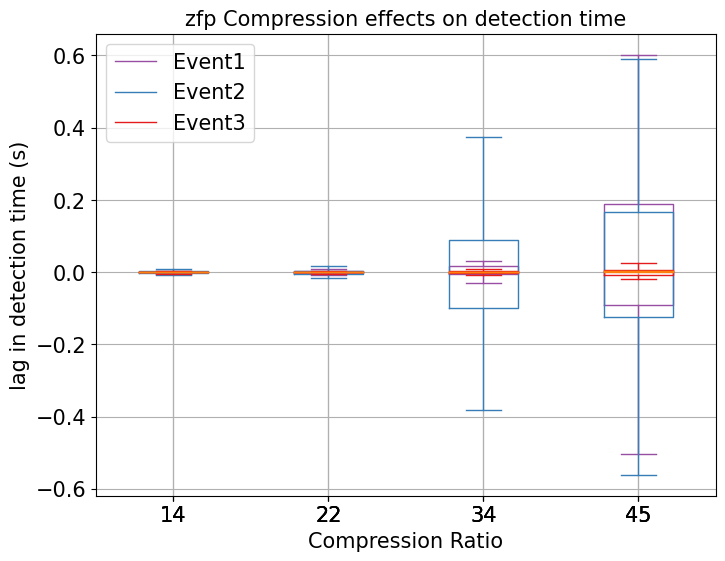

In [23]:
fsize=15
labels=[str(int(sizes[0]/sizes[a])) for a in range(2,6)]
colors=["#984ea3","#377eb8","#e41a1c"]
bps=[]
plt.figure(figsize=(8, 6))
for b in range(len(peakWindows)):
    boxpData=[peakLocations_zfp[a,:,b]-peakLocations_zfp[0,:,b] for a in range(1,5)]
    bp=plt.boxplot(boxpData, labels=labels, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'caps']: #['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']
            plt.setp(bp[element], color=colors[b])
    bps.append(bp)
plt.grid()
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel("lag in detection time (s)",fontsize=fsize)
plt.xlabel("Compression Ratio",fontsize=fsize)
plt.title("zfp Compression effects on detection time",fontsize=fsize)
plt.legend([a["boxes"][0] for a in bps],["Event1","Event2","Event3"],fontsize=fsize)

### SVD (randomized) compression analysis

For 3 event time windows (see the Three\_Events.ipynb file for more info), the template matching times of the randomized SVD compressed/decompressed data are calculated, as well as the times resulting from template matching of the raw data. This is repeated for each SVD compression ratio.

In [24]:
def randomized_SVD_comp_decomp(data, compFactor):
    from sklearn.utils.extmath import randomized_svd

    rows, columns = data.shape
    approxRank = int((rows * columns) / (compFactor * (rows + columns)))
    U, S, Vt = randomized_svd(data, n_components=approxRank)
    recon = U @ np.diag(S) @ Vt
    return recon


peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
timeLag=np.linspace(0,lagmax/1000,lagmax)
chosen_channels_signal= signalToUse #[channelsToUse]
chosen_channels_template = template #[channelsToUse]
lag_zero=len(template[1])-1
number_of_channels=len(signalToUse)
peakLocations_svd=np.empty((1,number_of_channels,len(peakWindows)))
for comp_ratio in compression_ratios:
    if comp_ratio == 0:
        decompressed_signal = filtered_signalToUse
        decompressed_template = filtered_template
    else:
        decompressed_signal = randomized_SVD_comp_decomp(chosen_channels_signal, comp_ratio)
        decompressed_template = randomized_SVD_comp_decomp(chosen_channels_template, comp_ratio)
        decompressed_signal = general_funcs.frequency_filter(decompressed_signal, [1, 15], "bandpass", 5, 1000)
        decompressed_template = general_funcs.frequency_filter(decompressed_template, [1, 15], "bandpass", 5, 1000)
    peakLocs=np.empty((1,len(peakWindows)))
    for a in range(number_of_channels):
        oneChannelTM=ss.correlate(decompressed_signal[a], decompressed_template[a])
        oneChannelTM=oneChannelTM[lag_zero:lag_zero+lagmax]
        peaks=[]
        for b in peakWindows:
            max_idx, max_val = max(enumerate(oneChannelTM[b[0]:b[1]]), key=operator.itemgetter(1)) 
            peaks.append(timeLag[max_idx+ b[0]])
        peakLocs=np.append(peakLocs, np.array([peaks]), axis=0)
    peakLocs=peakLocs[1:]
    peakLocations_svd=np.append(peakLocations_svd, peakLocs[np.newaxis], axis=0)

peakLocations_svd=peakLocations_svd[1:]

Plot the distribution across all channels of differences between each randomized SVD compression factor's picked times and the original data's picked times for all three events.

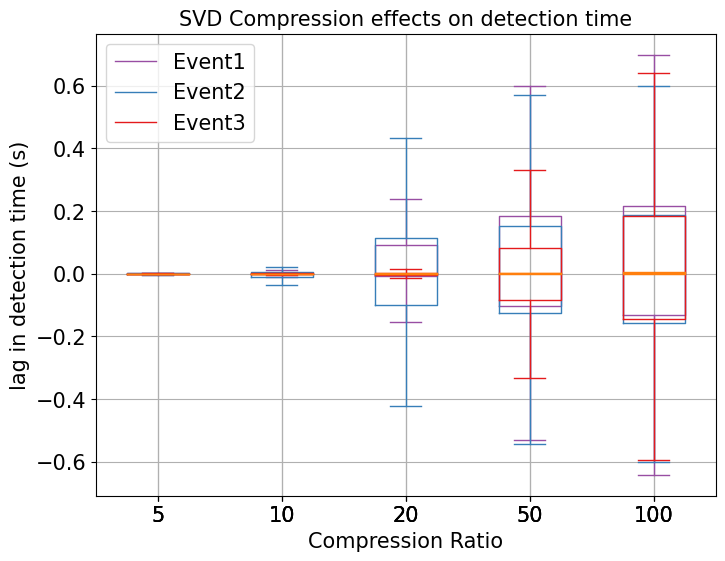

In [25]:
fsize=15
labels=[str(compression_ratios[a]) for a in range(1,6)]
colors=["#984ea3","#377eb8","#e41a1c"]
bps=[]
plt.figure(figsize=(8, 6))
for b in range(len(peakWindows)):
    boxpData=[peakLocations_svd[a,:,b]-peakLocations_svd[0,:,b] for a in range(1,6)]
    bp=plt.boxplot(boxpData, labels=labels, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'caps']: #['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']
            plt.setp(bp[element], color=colors[b])
    bps.append(bp)
plt.grid()
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel("lag in detection time (s)",fontsize=fsize)
plt.xlabel("Compression Ratio",fontsize=fsize)
plt.title("SVD Compression effects on detection time",fontsize=fsize)
plt.legend([a["boxes"][0] for a in bps],["Event1","Event2","Event3"],fontsize=fsize)

Same plot as above, but only showing up to 50x compression.

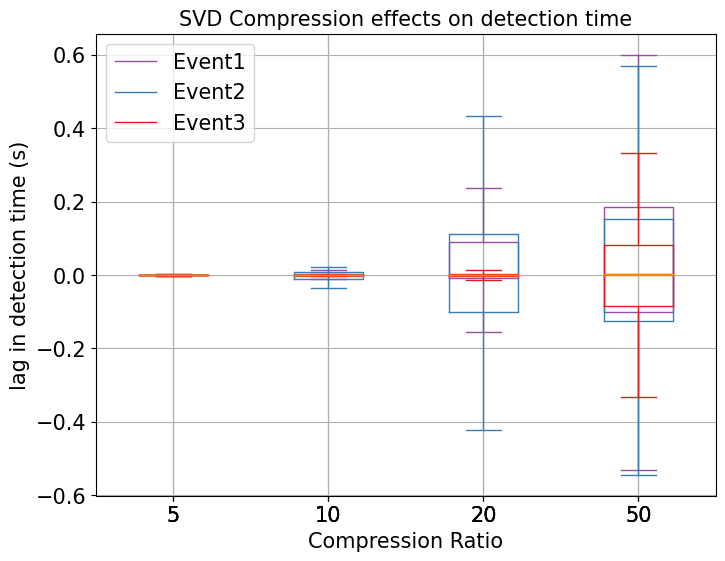

In [26]:
fsize=15
labels=[str(compression_ratios[a]) for a in range(1,5)]
colors=["#984ea3","#377eb8","#e41a1c"]
bps=[]
plt.figure(figsize=(8, 6))
for b in range(len(peakWindows)):
    boxpData=[peakLocations_svd[a,:,b]-peakLocations_svd[0,:,b] for a in range(1,5)]
    bp=plt.boxplot(boxpData, labels=labels, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'caps']: #['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']
            plt.setp(bp[element], color=colors[b])
    bps.append(bp)
plt.grid()
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel("lag in detection time (s)",fontsize=fsize)
plt.xlabel("Compression Ratio",fontsize=fsize)
plt.title("SVD Compression effects on detection time",fontsize=fsize)
plt.legend([a["boxes"][0] for a in bps],["Event1","Event2","Event3"],fontsize=fsize)